# Transfer Learning in TensorFlow: Scaling Up

* **The goal** is to beat the original Food101 paper with 10% of the training, by leveraging deep learning and transfer learning.

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [2]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Importing helper functions
!wget "https://raw.githubusercontent.com/molleremil/helper_functions/main/tf_helper_func.py"

--2023-12-10 10:41:16--  https://raw.githubusercontent.com/molleremil/helper_functions/main/tf_helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10304 (10K) [text/plain]
Saving to: ‘tf_helper_func.py’

tf_helper_func.py   100%[===================>]  10.06K  --.-KB/s    in 0s      

2023-12-10 10:41:16 (96.5 MB/s) - ‘tf_helper_func.py’ saved [10304/10304]



In [4]:
from tf_helper_func import plot_loss_curves, create_tensorboard_callback, unzip_data, compare_histories, walk_through_dir

## 1. Import and Preprocess Data

In [5]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
unzip_data("101_food_classes_10_percent.zip")

--2023-12-10 10:41:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   206MB/s    in 8.7s    

2023-12-10 10:41:26 (179 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_f

In [7]:
# Setup train and test dirs
train_dir_10_pct = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

IMG_SIZE = (224, 224)

# Setup data loaders
train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_pct,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
train_data_10_pct.class_names, len(train_data_10_pct.class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

## 2. Build and train model_0

Steps:
* Create a ModelCheckpoint callback
* Create a data augmentation layer
* Build base_model: Topless Functional EfficientNetV2B0 model
* Feature extract for 5 full passes (5 epochs on the train set and validate on 15% of the test data, to save epoch time)

In [9]:
# Create ModelCheckpoint callback
checkpoint_path = "modelcheckpoint_callback/checkpoint.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      monitor="val_accuracy")

In [10]:
# Create data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal")
], name="data_augmentation_layer")

input_shape = (224, 224, 3)
initial_epochs = 5

# Build model architecture with trainable top layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(len(train_data_10_pct.class_names), activation="softmax", name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

# Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model

history_101_10_pct_data_aug = model_0.fit(train_data_10_pct,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_pct),
                                          validation_data=test_data,
                                          validation_steps=int(0.15*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="model_0"),
                                                     model_checkpoint_callback])

24274472/24274472 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/model_0/20231210-104152
Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5229 - accuracy: 0.2388
Epoch 1: val_accuracy improved from -inf to 0.42055, saving model to modelcheckpoint_callback/checkpoint.ckpt
237/237 [==============================] - 131s 481ms/step - loss: 3.5229 - accuracy: 0.2388 - val_loss: 2.6725 - val_accuracy: 0.4206
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4543 - accuracy: 0.4459
Epoch 2: val_accuracy improved from 0.42055 to 0.48835, saving model to modelcheckpoint_callback/checkpoint.ckpt
237/237 [==============================] - 80s 336ms/step - loss: 2.4543 - accuracy: 0.4459 - val_loss: 2.1881 - val_accuracy: 0.4883
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0676 - accuracy: 0.5096
Epoch 3: val_accuracy improved from 0.48835 to 0.50636, saving model to modelcheckp

In [11]:
# Evaluate on the entire test dataset
results_all_10_pct_data_aug = model_0.evaluate(test_data)
results_all_10_pct_data_aug

790/790 [==============================] - 55s 70ms/step - loss: 1.6488 - accuracy: 0.5630


[1.648838758468628, 0.5630099177360535]

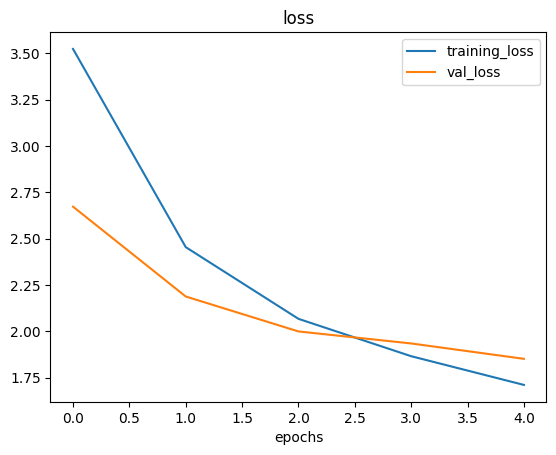

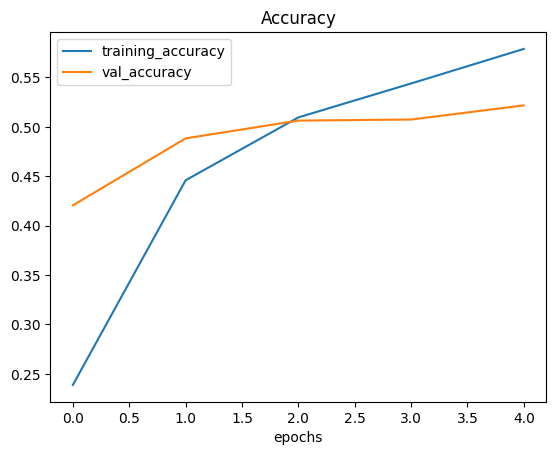

In [12]:
plot_loss_curves(history_101_10_pct_data_aug)

## 3. Prepare for fine-tuning

In [13]:
# Check index of untrainable layers
for index, layer in enumerate(model_0.layers):
  print(index, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetv2-b0 False
3 global_avg_pool_layer True
4 output_layer True


In [14]:
for index, layer in enumerate(model_0.layers[2].layers):
  if layer.trainable == True:
    print(index, layer.name)

* No layers inside `base_model` are trainable. Let's unfreeze the top 5 layers

In [15]:
# Unfreeze top 5 layers
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
for index, layer in enumerate(base_model.layers):
  if layer.trainable == True:
    print(index, layer.name)

265 block6h_drop
266 block6h_add
267 top_conv
268 top_bn
269 top_activation


In [17]:
for index, layer in enumerate(model_0.layers[2].layers):
  print(index, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

* Top 10 layers in the model are now unfrozen

In [18]:
# Recompile model with lower learning rate (0.0001 -> 10x lower than initial)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

fine_tune_epochs = initial_epochs + 5
history_101_fine_10_pct_data_aug = model_0.fit(train_data_10_pct,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_pct),
                                               validation_data=test_data,
                                               validation_steps=int(0.15*len(test_data)),
                                               initial_epoch=history_101_10_pct_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="model_0_fine_tune_1")])

Saving TensorBoard log files to: transfer_learning/model_0_fine_tune_1/20231210-105051
Epoch 5/10
237/237 [==============================] - 67s 239ms/step - loss: 1.5006 - accuracy: 0.6260 - val_loss: 1.8268 - val_accuracy: 0.5220
Epoch 6/10
237/237 [==============================] - 51s 212ms/step - loss: 1.4272 - accuracy: 0.6308 - val_loss: 1.8082 - val_accuracy: 0.5230
Epoch 7/10
237/237 [==============================] - 47s 196ms/step - loss: 1.3696 - accuracy: 0.6474 - val_loss: 1.8034 - val_accuracy: 0.5257
Epoch 8/10
237/237 [==============================] - 44s 181ms/step - loss: 1.3196 - accuracy: 0.6500 - val_loss: 1.8042 - val_accuracy: 0.5238
Epoch 9/10
237/237 [==============================] - 43s 181ms/step - loss: 1.2957 - accuracy: 0.6582 - val_loss: 1.8001 - val_accuracy: 0.5238
Epoch 10/10
237/237 [==============================] - 43s 178ms/step - loss: 1.2535 - accuracy: 0.6735 - val_loss: 1.7947 - val_accuracy: 0.5307


In [19]:
# Evaluate on the entire test data
results_all_fine_10_pct_data = model_0.evaluate(test_data)

790/790 [==============================] - 63s 80ms/step - loss: 1.4957 - accuracy: 0.5986


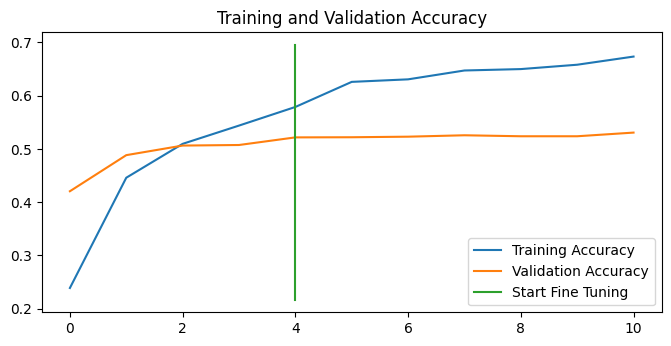

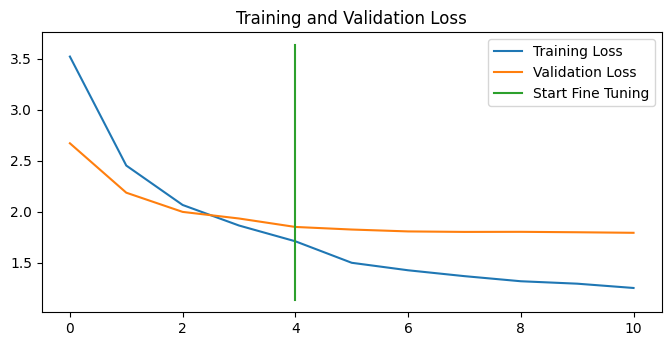

In [20]:
compare_histories(original_history=history_101_10_pct_data_aug, post_history=history_101_fine_10_pct_data_aug, initial_epochs=initial_epochs)

## 4. Save and load the model

In [21]:
# Save fine-tuned model
model_0.save("drive/MyDrive/101_food_classes_10_percent_saved_model")

In [22]:
# Load model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_saved_model")

In [23]:
# Evaluate loaded model and compare performance to presaved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 72ms/step - loss: 1.4957 - accuracy: 0.5986


[1.4957112073898315, 0.5986138582229614]

In [24]:
# Compare loaded_model results with presaved model results (should be the same or "very close")
results_all_fine_10_pct_data

[1.4957112073898315, 0.5986138582229614]

In [25]:
import numpy as np
np.isclose(loaded_model_results, results_all_fine_10_pct_data)

array([ True,  True])

In [26]:
loaded_model_results == results_all_fine_10_pct_data

True

## Evaluate the performance of the model across all different classes

- Make predictions, visualize them and then later find out which predictions were the "most" wrong

In [27]:
# Load in a presaved model, prepared earlier
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-12-10 11:01:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.207, 173.194.213.207, 173.194.215.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   137MB/s    in 0.3s    

2023-12-10 11:01:35 (137 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [29]:
# Instantiate model
model_1 = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [30]:
# Evaluate loaded model on test data
results_downloaded_model = model_1.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 63s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with trained model

In [31]:
# Make predictions with model
preds_prob = model_1.predict(test_data, verbose=1)

790/790 [==============================] - 65s 80ms/step


In [32]:
# How many predictions are there
len(preds_prob)

25250

In [33]:
# What's the shape of our predictions
preds_prob.shape

(25250, 101)

In [34]:
# What does the first 10 predictions look like
preds_prob[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [35]:
# What does the first prediction probability array look like?
preds_prob[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [36]:
preds_prob[0].max(), preds_prob[0].argmax()

(0.8474181, 52)

In [37]:
for index, pred in enumerate(preds_prob[0]):
  if pred > 0.8:
    print(index, pred)

52 0.8474181


In [38]:
for index, food_class in enumerate(test_data.class_names):
  print(index, food_class)

0 apple_pie
1 baby_back_ribs
2 baklava
3 beef_carpaccio
4 beef_tartare
5 beet_salad
6 beignets
7 bibimbap
8 bread_pudding
9 breakfast_burrito
10 bruschetta
11 caesar_salad
12 cannoli
13 caprese_salad
14 carrot_cake
15 ceviche
16 cheese_plate
17 cheesecake
18 chicken_curry
19 chicken_quesadilla
20 chicken_wings
21 chocolate_cake
22 chocolate_mousse
23 churros
24 clam_chowder
25 club_sandwich
26 crab_cakes
27 creme_brulee
28 croque_madame
29 cup_cakes
30 deviled_eggs
31 donuts
32 dumplings
33 edamame
34 eggs_benedict
35 escargots
36 falafel
37 filet_mignon
38 fish_and_chips
39 foie_gras
40 french_fries
41 french_onion_soup
42 french_toast
43 fried_calamari
44 fried_rice
45 frozen_yogurt
46 garlic_bread
47 gnocchi
48 greek_salad
49 grilled_cheese_sandwich
50 grilled_salmon
51 guacamole
52 gyoza
53 hamburger
54 hot_and_sour_soup
55 hot_dog
56 huevos_rancheros
57 hummus
58 ice_cream
59 lasagna
60 lobster_bisque
61 lobster_roll_sandwich
62 macaroni_and_cheese
63 macarons
64 miso_soup
65 muss

In [39]:
test_data.class_names[52]

'gyoza'

In [40]:
pred_classes = preds_prob.argmax()

In [41]:
pred_classes

153526

In [42]:
pred_classes = tf.argmax(preds_prob, axis=1)

In [43]:
pred_classes

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([ 52,   0,   0, ..., 100,  94, 100])>

In [44]:
pred_classes[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])>

To evaluate the predictions array of all the model's predictions we need to compare them to the labels.

In [45]:
# To get the test labels we need to unravel the test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels come in form of one hot encoded arrays such as [0, 0, 0, 1, ... 0, 0] and we want the idnex value where 1 occurs.
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
len(y_labels)

25250

## Evaluating model's performance

- One way to check that the model's predictions array matches the order of the test labels array is to find the accuracy score.

In [47]:
# Use scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)

In [48]:
sklearn_accuracy

0.6077623762376237

In [49]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [50]:
np.isclose(sklearn_accuracy, results_downloaded_model[1])

True

## Making a confusion matrix

In [51]:
class_names = test_data.class_names

In [52]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# This function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [53]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize=(100, 100),
                      text_size=20)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [55]:
# Get a dictionary of the classification report
classification_report_dict= classification_report(y_true=y_labels,
                            y_pred=pred_classes,
                            output_dict=True)

In [56]:
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

* Make plot of all classes with their F1-scores

In [57]:
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [58]:
# Turn f1-scores into a DataFrame for visualization
import pandas as pd
class_f1_df = pd.DataFrame.from_dict(class_f1_scores, orient="index").sort_values(by=0, ascending=False)

In [59]:
class_f1_df

0
edamame              0.937143
macarons             0.895397
pho                  0.866538
spaghetti_carbonara  0.847656
oysters              0.834008
...                       ...
huevos_rancheros     0.339833
chocolate_mousse     0.329159
pork_chop            0.308756
foie_gras            0.297491
apple_pie            0.240566

[101 rows x 1 columns]

In [60]:
# More structured DataFrame
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "F1-score": list(class_f1_scores.values())}).sort_values(by="F1-score", ascending=False)

In [61]:
f1_scores[:-10]

class_names  F1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

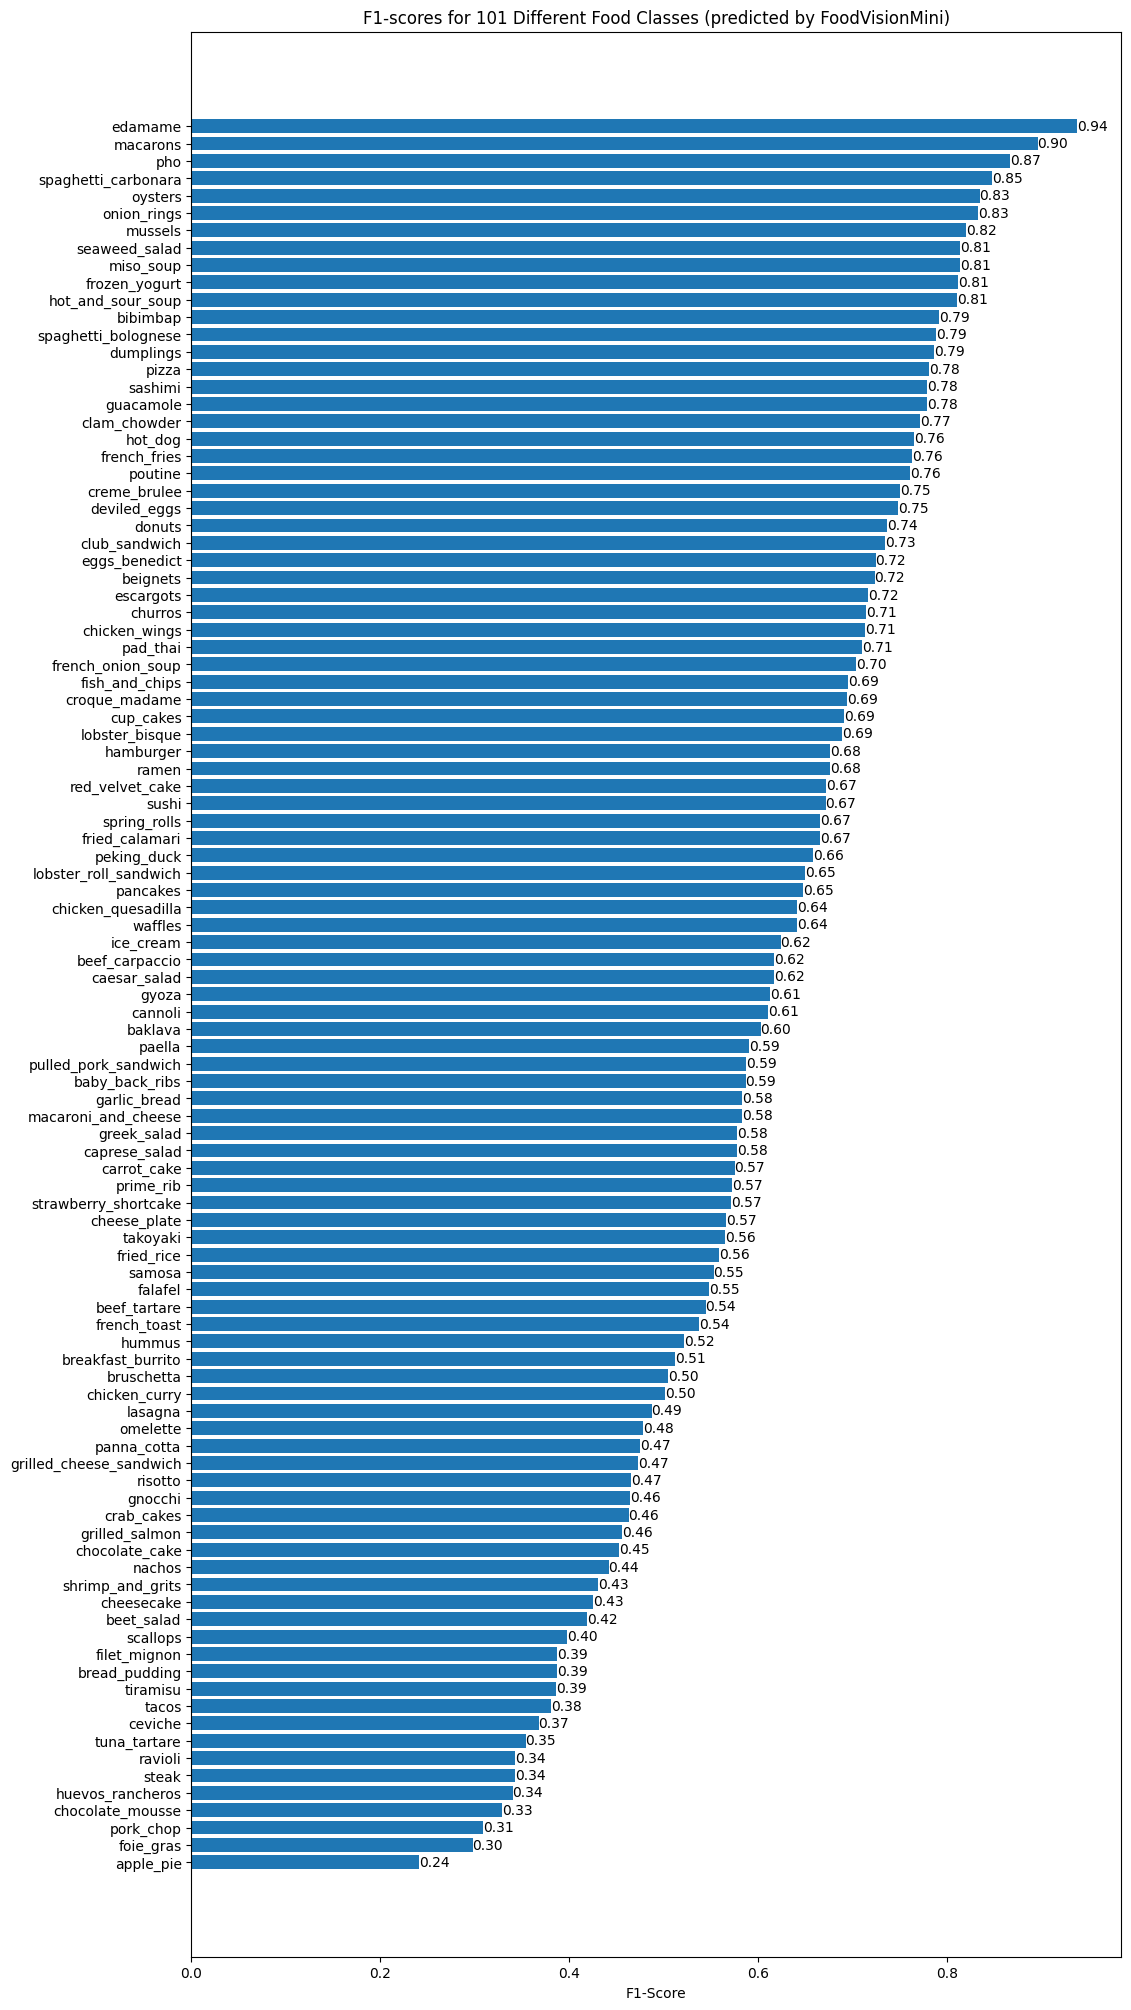

In [67]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["F1-score"])
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by FoodVisionMini)")
ax.invert_yaxis()
ax.bar_label(scores, fmt='%.2f')
plt.show();

#ax.set_xlim(right=15);
#plt.xlabel("F1-score")
#plt.ylabel("Class Name")
#plt.title("Classes vs F1-scores", fontsize=100)


In [71]:
def load_and_prep_image(filename, img_shape, scale=True):
  # Load image
  img = tf.io.read_file(filename)
  # Decode image
  img = tf.io.decode_image(img, channels=3)
  # Resize image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Scale?
  if scale:
    return img/255.
  else:
    return img


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


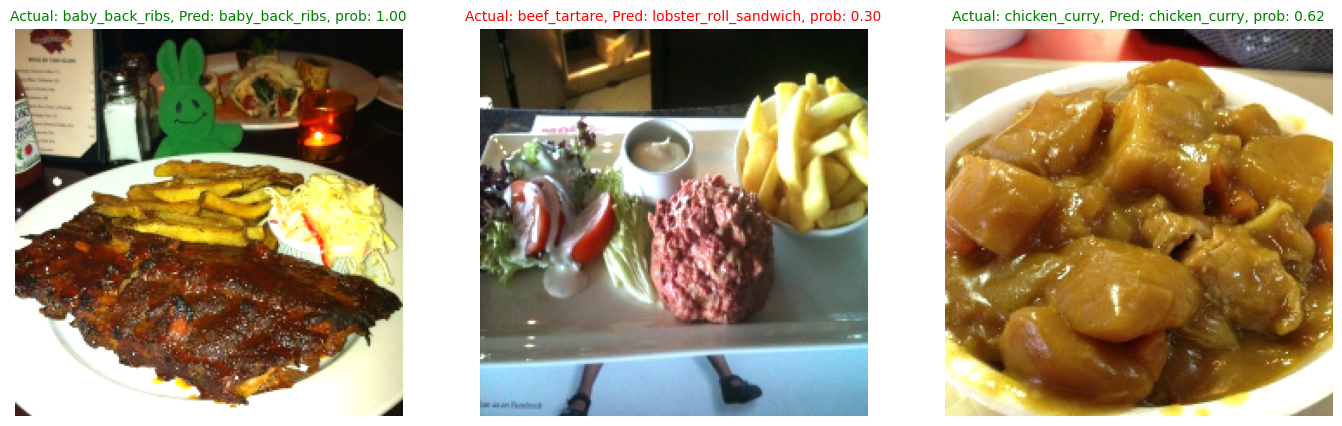

In [88]:
# Make preds on random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random images from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, 224, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model_1.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediciton probability index and match is to class names list
  #print(pred_prob)
  #print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/225.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color, fontsize=10)
  plt.axis(False);



## Finding the most wrong predictions

To find out where the model is most wrong, let's write some code to find out the following:
1. Get all of the images file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from the model), max prediciton probabilities, prediction class names, ground truth class names.
3. Use the DataFrame to find all the wrong predictions (where the ground truth labels doesn't match the predictions)
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediciton.

In [109]:
# 1. Get all the image file paths of test dataet
imgfilepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  imgfilepaths.append(filepath.numpy())
imgfilepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [146]:
# 2. Create DataFrame
df = pd.DataFrame({"filepath": imgfilepaths,
                   "y_true": y_labels,
                   "y_pred": pred_classes,
                   "pred_conf": preds_prob.max(axis=1), # get the maximum probability value
                   "y_true_classname": [class_names[i] for i in y_labels],
                   "y_pred_classname": [class_names[i] for i in pred_classes]})

In [147]:
df.head()

filepath  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847418        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658607        apple_pie  pulled_pork_sandwich  
4   0.367901        apple_pie             prime_rib

In [148]:
# 3. Find out which predictions are wrong
df["pred_correct"] = df["y_true"] == df["y_pred"]

In [149]:
df.head()

filepath  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [150]:
# 4. Sort DataFrame to have most wrong predictions at the top
top_100_wrong = df[df["pred_correct"] == False].sort_values(by="pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

filepath  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

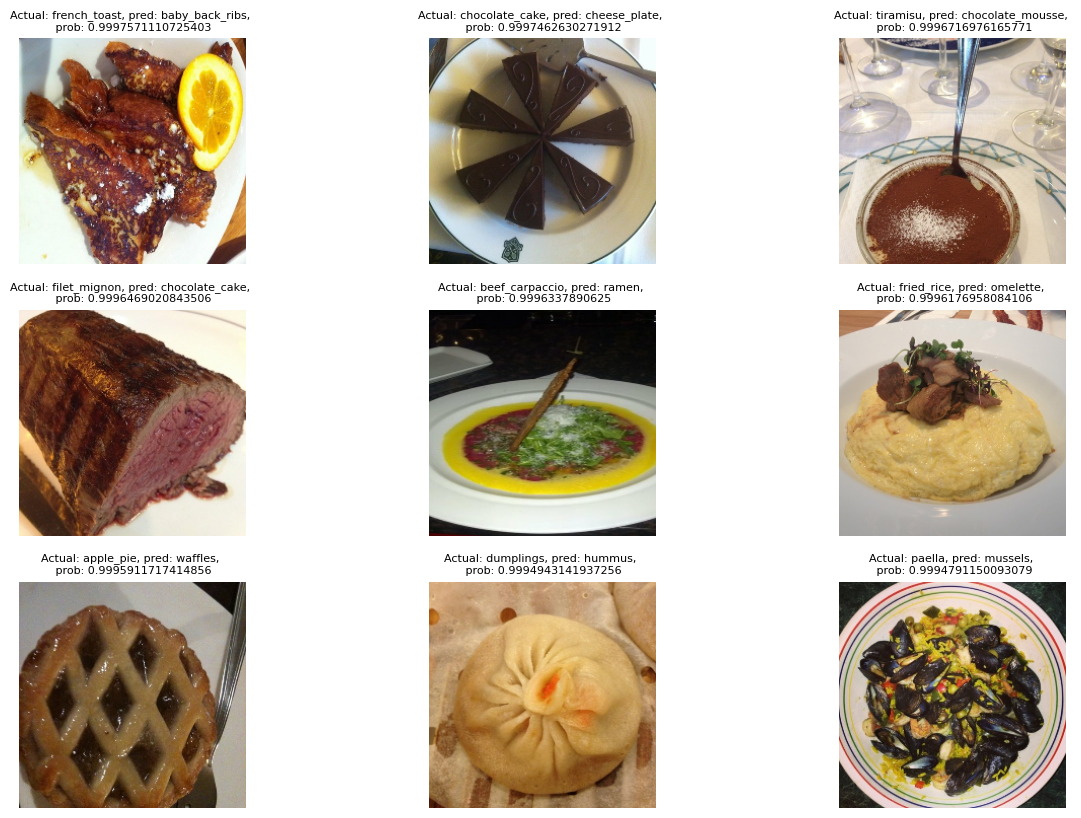

In [162]:
# 5. Visualize the test data samples which have the wrong prediciton but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], img_shape=224, scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname}, \n prob: {pred_prob}", fontsize=8)
  plt.axis(False)